In [389]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import time

from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', 100)

# Read Data

## Amazon Fashion

### With styles

In [25]:
df = pd.read_pickle('Data/amazon_data_with_styles')
df.head()

,rating,verified,reviewTime,user,item,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,Style:,Size Name:,Metal Type:,Item Display Length:,Size:,Color:,Team Name:,Length:,Material:,Item Package Quantity:,Scent Name:,Gem Type:,Shape:,Format:,Style Name:,Package Quantity:
0,5.0,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,True,"09 28, 2014",A3DDWDH9PX2YX2,7106116521,Sonja Lau,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",1411862400,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,False,"08 25, 2014",A2MWC41EW7XL15,7106116521,Kathleen,Love these... I am going to order another pack...,My New 'Friends' !!,1408924800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,True,"08 24, 2014",A2UH2QQ275NV45,7106116521,Jodi Stoner,too tiny an opening,Two Stars,1408838400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,False,"07 27, 2014",A89F3LQADZBS5,7106116521,Alexander D.,Okay,Three Stars,1406419200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Without styles

In [390]:
df = pd.read_csv('Data/amazon_fashion.csv', names=['item','user','rating'])
df.head()

,item,user,rating
0,7106116521,A1D4G1SNUZWQOT,5.0
1,7106116521,A3DDWDH9PX2YX2,2.0
2,7106116521,A2MWC41EW7XL15,4.0
3,7106116521,A2UH2QQ275NV45,2.0
4,7106116521,A89F3LQADZBS5,3.0


In [391]:
df['rating'] = df['rating'].astype(int)

## MovieLens

In [377]:
df = pd.read_csv('Data/movie_lens_ratings_small.csv').drop(columns=['timestamp'])
df.head()
df.columns = ['user', 'item', 'rating']
print('rating interval:', df.rating.unique().min(), ',', df.rating.unique().max())
df.head()

rating interval: 0.5 , 5.0


,user,item,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


# Data Exploration

First filtering active users and rated items with x or more ratings:

In [392]:
item_thres = 1
user_thres = 1

In [393]:
df['#ratings'] = df.groupby('item')['item'].transform('count')
df = df[df['#ratings'] >= item_thres].drop(columns=['#ratings'])

df['#ratings'] = df.groupby('user')['user'].transform('count')
df = df[df['#ratings'] >= user_thres].drop(columns=['#ratings'])

In [394]:
norpu = df.groupby('user')['rating'].count().mean()
total_users = df.user.unique().size
total_items = df.item.unique().size

## Sub Sample

In [328]:
df = df.sample(frac=0.1, random_state=1234)

rows  883636 
#ratings 883636 
#ratings/user 1.18 
average rating 3.91 
#users  749233 
#items  186189


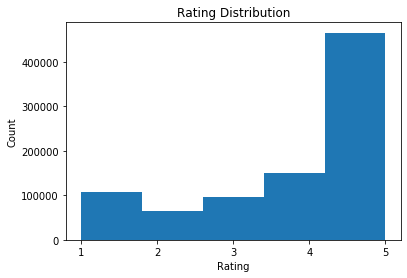

In [395]:
print('rows ', len(df), '\n#ratings', len(df[df['rating'] != 0]), '\n#ratings/user', round(norpu,2), '\naverage rating', "{0:.2f}".format(np.average(df['rating'])), '\n#users ', df['user'].unique().size, '\n#items ', df['item'].unique().size)
df.hist(column='rating', bins=5, grid=False)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(range(1,6))
plt.show()

## Style analysis

In [30]:
keys = ['Style:',
 'Size Name:',
 'Metal Type:',
 'Item Display Length:',
 'Size:',
 'Color:',
 'Team Name:',
 'Length:',
 'Material:',
 'Item Package Quantity:',
 'Scent Name:',
 'Gem Type:',
 'Shape:',
 'Format:',
 'Style Name:',
 'Package Quantity:']

In [48]:
style_perc_present = []
for style in keys:
    style_perc_present.append(1 - df[style].isnull().sum() / len(df))

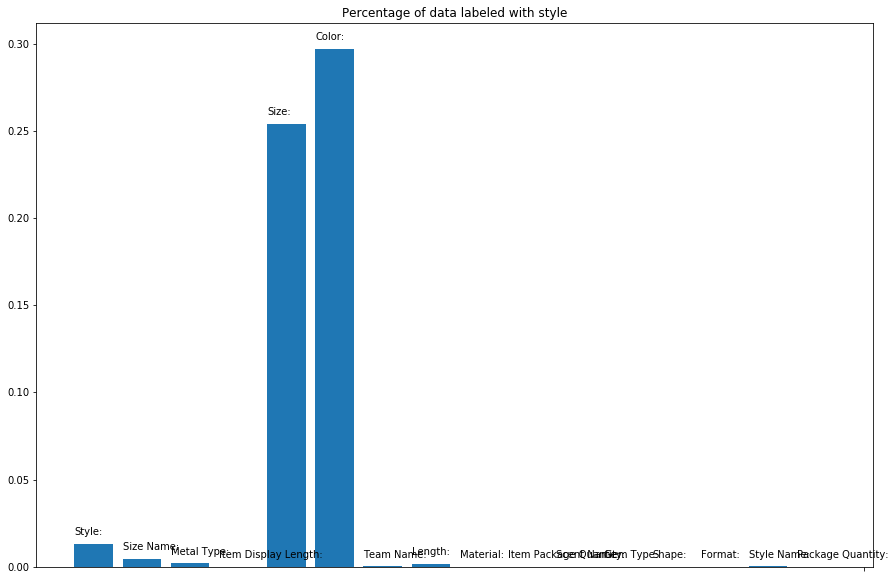

In [64]:
plt.rcParams['figure.figsize'] = [15,10]
bars = plt.bar(keys, style_perc_present)
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 0.005, keys[i])
plt.title('Percentage of data labeled with style')
plt.xticks('')
plt.show()

In [215]:
color_keys = list(df.groupby('Color:')['rating'].count().sort_values(ascending=False)[0:35].index) 

color_perc_present = []
for value in df.groupby('Color:')['rating'].count().sort_values(ascending=False)[0:35]:
    color_perc_present.append(value / (len(df) - df['Color:'].isnull().sum()))

color_keys.append('Others')
color_perc_present.append((df.groupby('Color:')['rating'].count().sort_values(ascending=False)[35:]/(len(df) - df['Color:'].isnull().sum())).sum())

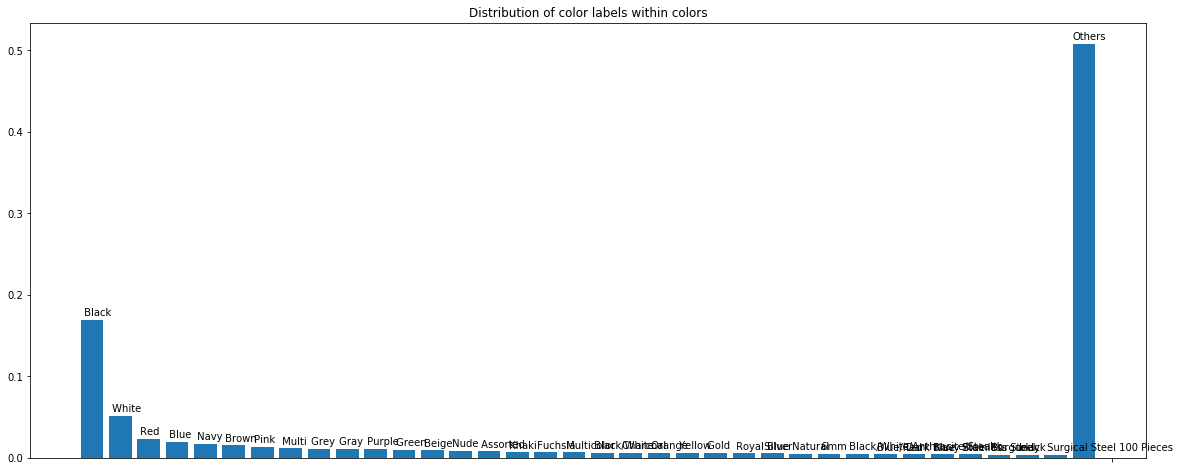

In [216]:
plt.rcParams['figure.figsize'] = [20,8]
bars = plt.bar(color_keys, color_perc_present)
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 0.005, color_keys[i])
plt.title('Distribution of color labels within colors')
plt.xticks('')
plt.show()

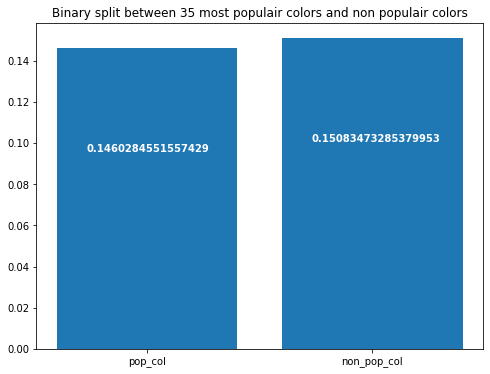

In [219]:
plt.rcParams['figure.figsize'] = [8,6]
pop_col = (df.groupby('Color:')['rating'].count().sort_values(ascending=False)[0:35]/len(df)).sum()
non_pop_col = (df.groupby('Color:')['rating'].count().sort_values(ascending=False)[35:]/len(df)).sum()

bars = plt.bar(['pop_col', 'non_pop_col'], [pop_col, non_pop_col])
plt.text(bars[0].get_x() + 0.13, pop_col + -0.05, pop_col, color="white", fontweight = 'bold')
plt.text(bars[1].get_x() + 0.13, non_pop_col + -0.05, non_pop_col, color="white", fontweight = 'bold')
plt.title('Binary split between 35 most populair colors and non populair colors')
plt.show()

In [230]:
pop_colors = df.groupby('Color:')['rating'].count().sort_values(ascending=False)[0:35] 

def pop_color(x):
    x = x['Color:']
    if x in pop_colors:
        return 1
    elif x not in pop_colors:
        return 0
    else:
        return False

In [245]:
temp_df = pd.DataFrame()

In [246]:
temp_df['bin_pop_col'] = df.apply(pop_color, axis=1, result_type='expand')

In [250]:
df = df.merge(temp_df, left_index=True, right_index=True)

# Model

In [396]:
class SVD:
    """" All functions used to run, test, plot and store the
    Singular Value Decomposition Model"""

    def __init__(self, params, total_users, total_items):
        self.nolf = params['nolf']
        self.n_epochs = params['n_epochs']
        self.alpha = params['alpha']
        self.alpha_b = params['alpha_b']
        self.use_bias = params['use_bias']
        self.use_impl_fb = params['use_impl_fb']
        self.bu_reg = params['bu_reg']
        self.bi_reg = params['bi_reg']
        self.pu_reg = params['pu_reg']
        self.qi_reg = params['qi_reg']
        self.x_reg = params['x_reg']
        self.stop = params['stop']
        self.random_state = params['random_state']
        self.total_users = total_users
        self.total_items = total_items
        self.params = params
        self.mu = 0 
        self.N = []
        self.N_test = []

        self.train_data = pd.DataFrame()
        self.test_data = pd.DataFrame()
        self.val_data = pd.DataFrame()
        self.train_time = 0
        self.model = {}
        self.test_results = {}

    def fit(self, train_data, val_data=[], verbose=1, plot=True):
        self.train_data = train_data
        self.val_data = val_data
        self.SVD(train_data=train_data, val_set=val_set, verbose=verbose, plot=plot)
        return self

    
###############################################################################################
    
    def SVD(self, train_data, val_set, verbose, plot):
        """"The SVD algorithm with sgd
        input: rating dataset with columns:['rating', 'user_id', 'item_id']
        output: the resulting p, q, bi, bu matrices"""
        self.mu = self.create_mu(train_data)
        train_matrix = self.create_matrix(train_data, total_users, total_items)
        
        tuples_train = [tuple(x) for x in train_data[['new_user_id', 'new_item_id', 'rating']].to_numpy()]
        b_user = np.zeros(total_users)
        b_item = np.zeros(total_items)

        p = np.random.normal(0, .1, (total_users, self.nolf))  # users
        q = np.random.normal(0, .1, (total_items, self.nolf))  # items

        x = np.random.normal(0, .1, (total_items, self.nolf)) # implicit fb rated, not rated
        impl_fb_u = np.zeros(self.nolf)
        
        if self.use_impl_fb:
            print('Creating N, for incorporating implicit feedback')
            self.N = train_data.groupby('new_user_id')['new_item_id'].apply(list)
        
        sqrt_Nu = 0
        rmses = []
        val_rmses = []
        val_rmse = "na"
        start = time.time()
        for epoch in range(self.n_epochs):
            total_sq_error = 0
            for u, i, r_ui in tuples_train:
                u = int(u)
                i = int(i)
                if self.use_impl_fb:
                    impl_fb_u = np.zeros(self.nolf)
                    sqrt_Nu = np.sqrt(len(self.N[u]))
                    for j in self.N[u]:
                        impl_fb_u += x[j] / sqrt_Nu
                    
#                     impl_fb_u = np.zeros(self.nolf)
#                     sqrt_Nu = np.sqrt(len(self.N[u]))
#                     for j in self.N[u]:
#                         r_uj = train_matrix[u,j]
# #                         r_uj = list(train_data[(train_data['new_item_id'] == j) & (train_data['new_user_id'] == u)]['rating'])
#                         if r_uj > 0:
#                             if r_uj < self.mu + b_user[u]:
#                                 impl_fb_u -= x[j] / sqrt_Nu
#                             if r_uj > self.mu + b_user[u]:
#                                 impl_fb_u += x[j] / sqrt_Nu

                if self.use_bias:
                    error = r_ui - ((self.mu + b_user[u] + b_item[i]) + np.dot(p[u] + impl_fb_u, q[i]))
                    b_user[u] += self.alpha_b * (error - self.bu_reg * b_user[u])
                    b_item[i] += self.alpha_b * (error - self.bi_reg * b_item[i])
                else:
                    error = r_ui - np.dot(p[u], q[i])

                p[u] += self.alpha * (error * q[i] - self.pu_reg * p[u])
                q[i] += self.alpha * (error * (p[u] + impl_fb_u) - self.qi_reg * q[i])
                total_sq_error += np.square(error)
            
                if self.use_impl_fb:
                    for j in self.N[u]:
                        x[j] += self.alpha * (error * q[i] / sqrt_Nu - self.x_reg * x[j])
                
            rmse = np.sqrt(total_sq_error / len(tuples_train))
            rmses.append(rmse)
            
            self.model = {'p': p, 'q': q, 'bu':b_user, 'bi':b_item, 'x':x, 'rmse':rmses, 'val_rmse':val_rmses}
            if len(val_set) > 0:
                val_rmse = self.test(val_set, val=True)
                val_rmses.append(val_rmse)
                    
            if epoch % verbose == 0:
                if len(val_set) > 0:
                    print('Epoch:', epoch, '  RMSE:', rmse, ' Val_RMSE:', val_rmse)
                else:
                    print('Epoch:', epoch, '  RMSE:', rmse)
            
            if self.stop and val_rmses[-2:][0] < val_rmse:
                print('BREAK: Validation set not improving anymore')
                break
                
        if plot:
            self.plot_rmse(rmses, val_rmses)

        self.train_time = time.time() - start
        self.model = {'p': p, 'q': q, 'bu':b_user, 'bi':b_item, 'x':x, 'rmse':rmses, 'val_rmse':val_rmses}
#################################################################################################


    def create_matrix(self, X_train, n_users, n_items):
        n_users = df.user.unique().shape[0]
        n_items = df.item.unique().shape[0]

        r = X_train['new_user_id']
        c = X_train['new_item_id']
        d = X_train['rating']
        train_matrix = sparse.coo_matrix((d, (r, c)), shape=(n_users, n_items))
    
        return train_matrix.tocsr()
    
    def create_mu(self, train_set):
        # Better mean calculation according to https://sifter.org/~simon/journal/20061211.html
        va = train_set.groupby('new_user_id')['rating'].mean().var() #variance mean ratings users
        vb = train_set.groupby('new_item_id')['rating'].mean().var() #variance mean ratings items
        k = va/vb #variance proportion
        better_mu = (train_set['rating'].mean() + train_set['rating'].sum()) / (k+len(train_set))
        return better_mu
    
    def plot_rmse(self, rmse, val_rmses=[]):
        plt.plot(np.arange(len(rmse)), rmse)
        if len(val_rmses) > 0:
            plt.plot(np.arange(len(val_rmses)), val_rmses, color='red')
        plt.title('RMSE')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['Train', 'Validation'])
        plt.show()

    def test(self, test_data, val=False):
        if not val:
            self.test_data = test_data
        tuples_test = [tuple(x) for x in test_data[['new_user_id', 'new_item_id', 'rating']].to_numpy()]
        test_matrix = self.create_matrix(test_data, self.total_users, self.total_items)
        
        if self.use_impl_fb and val:
            self.N_test = self.val_data.groupby('new_user_id')['new_item_id'].apply(list)
        elif self.use_impl_fb:
            self.N_test = self.test_data.groupby('new_user_id')['new_item_id'].apply(list)
            
        total_error = 0
        estimates = []
        for u, i, r_ui in tuples_test:
            u = int(u)
            i = int(i)
            est = self.estimate(u, i, test_matrix)
            estimates.append(est)
            total_error += np.square(r_ui - est)
        
        rmse = np.sqrt(total_error / len(tuples_test))
        
        if not val:
            self.test_results = {'rmse': rmse, 'estimates':estimates}
            print('RMSE on test set:', self.test_results['rmse'])
        else:
            return rmse

    def estimate(self, u, i, test_matrix):
        est = self.mu + self.model['bu'][u] + self.model['bi'][i]
        impl_fb_u = np.zeros(self.nolf)
        
        if u in self.train_data['new_user_id'] and i in self.train_data['new_item_id']:
            
            if self.use_impl_fb and u in self.N.index:
                sqrt_Nu_test = np.sqrt(len(self.N_test[u]))
                for j in self.N_test[u]:   
                    impl_fb_u += self.model['x'][j] / sqrt_Nu_test
#                     r_uj = test_matrix[u,j]
#                     if r_uj > 0:
#                         if r_uj < self.mu + b_user[u]:
#                             impl_fb_u -= x[j] / sqrt_Nu_test
#                         if r_uj > self.mu + b_user[u]:
#                             impl_fb_u += x[j] / sqrt_Nu_test

            est += np.dot(self.model['p'][u] + impl_fb_u, self.model['q'][i])

        return est
    
    def store_results(self, log_path, res_name, user_thres, item_thres):
        train_size = round((len(self.train_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        test_size = round((len(self.test_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        val_size = round((len(self.val_data) / (len(self.train_data) + len(self.test_data) + len(self.val_data))),1)
        
        result_info = {'RMSE_test': self.test_results['rmse'], 'train_speed': round(self.train_time,2)}
        other_info = {'u_thres': user_thres,'i_thres': item_thres, 'train_size':train_size, 'test_size':test_size, 'val_size':val_size, 'train_rmse':self.model['rmse']}
        final_log = dict(result_info, **self.params, **other_info)

        if not os.path.exists(log_path + res_name):
            df_results = pd.DataFrame(columns=final_log.keys())
            print('new results created')

        else:
            df_results = pd.read_pickle(log_path + res_name)
            print('results added')

        df_results = df_results.append(final_log, ignore_index=True)
        pd.to_pickle(df_results, log_path + res_name)

# Data Prep
Create new ids for users and items that match the row and column indices of the user-item interaction matrix

In [397]:
items = df['item'].unique()
itemsDF = pd.DataFrame(data=items, columns=['original_item_id'])
itemsDF['new_item_id'] = itemsDF.index

users = df['user'].unique()
usersDF = pd.DataFrame(data=users, columns=['original_user_id'])
usersDF['new_user_id'] = usersDF.index

ratingDF = df.merge(itemsDF, left_on='item', right_on='original_item_id')
ratingDF = ratingDF.drop(columns=['original_item_id'])

ratingDF = ratingDF.merge(usersDF, left_on='user', right_on='original_user_id')
ratingDF = ratingDF.drop(columns=['original_user_id'])

df_new_ids = ratingDF
print('Full data #row: ', df_new_ids.shape[0], '\n#users: ', total_users, '\n#items: ', total_items)
df_new_ids.head()

Full data #row:  883636 
#users:  749233 
#items:  186189


,item,user,rating,new_item_id,new_user_id
0,7106116521,A1D4G1SNUZWQOT,5,0,0
1,7106116521,A3DDWDH9PX2YX2,2,0,1
2,B00J8WZBEG,A3DDWDH9PX2YX2,5,47122,1
3,7106116521,A2MWC41EW7XL15,4,0,2
4,7106116521,A2UH2QQ275NV45,2,0,3


## Train Test split
Train 0.8, Train 0.2, Test 0.1, could add validation set

In [398]:
random_state = 1234
train_set, test_set = train_test_split(df_new_ids, test_size=0.20, shuffle=True, random_state=random_state)
val_set, test_set = train_test_split(test_set, test_size=0.50, shuffle=True, random_state=random_state)

print('Size of train set: ', len(train_set))
print('Size of validation set: ', len(val_set))
print('Size of test set: ', len(test_set))

Size of train set:  706908
Size of validation set:  88364
Size of test set:  88364


# Params

In [399]:
params = {"nolf":15, #Size of latent feature vectors
"n_epochs":50,
"random_state":random_state,

#Learning rate
"alpha":0.004, #Low alpha to prevent diverging => sgd all over the place => error up
"alpha_b":0.004,

"stop":True,
"use_bias":True,
"use_impl_fb":False,

#Regularizers, still tweaking the values
"bu_reg":0.05,
"bi_reg":0.05,
"pu_reg":0.01,
"qi_reg":0.01,
"x_reg":0.01,
}

# Train and Test Model

## Model without impl_fb

Epoch: 0   RMSE: 1.3981511802905118  Val_RMSE: 1.3886493446975077
Epoch: 5   RMSE: 1.3042408129350196  Val_RMSE: 1.357703794794906
Epoch: 10   RMSE: 1.2393056975454753  Val_RMSE: 1.344062627339879
Epoch: 15   RMSE: 1.1790567011472373  Val_RMSE: 1.3346583087209276
Epoch: 20   RMSE: 1.1191681769215471  Val_RMSE: 1.327998717183779
Epoch: 25   RMSE: 1.0597579220183722  Val_RMSE: 1.3237498814536597
Epoch: 30   RMSE: 1.0020860733403987  Val_RMSE: 1.3211744757494617
Epoch: 35   RMSE: 0.9471046608183138  Val_RMSE: 1.3196142325119642
Epoch: 40   RMSE: 0.8951320100141524  Val_RMSE: 1.3186054954974182
Epoch: 45   RMSE: 0.8461764561120803  Val_RMSE: 1.3179197181099418


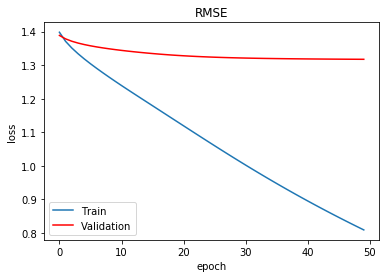

In [400]:
params['use_impl_fb'] = False
model = SVD(params, total_users, total_items)
model.fit(train_set, val_set, 5, plot=True)

In [401]:
model.test(test_set)

RMSE on test set: 1.319916335988349


## Model with impl_fb

Creating N, for incorporating implicit feedback
Epoch: 0   RMSE: 1.3962183590738364  Val_RMSE: 1.3899891356617866
Epoch: 5   RMSE: 1.294357865985788  Val_RMSE: 1.3623099499252604
Epoch: 10   RMSE: 1.2247173119424024  Val_RMSE: 1.3519961129126148
Epoch: 15   RMSE: 1.159711210567497  Val_RMSE: 1.3454588712069793
Epoch: 20   RMSE: 1.0953440620913193  Val_RMSE: 1.3413971520918306
Epoch: 25   RMSE: 1.0318046723219163  Val_RMSE: 1.3397875962000192
BREAK: Validation set not improving anymore


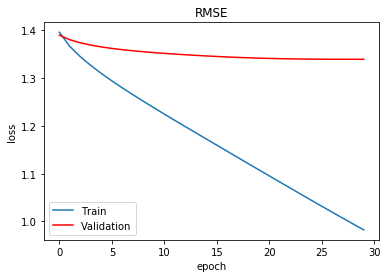

In [402]:
params['use_impl_fb'] = True
model2 = SVD(params, total_users, total_items)
model2.fit(train_set, val_set, 5, plot=True)

In [403]:
model2.test(test_set)

RMSE on test set: 1.3420718787158907


# Store Results

In [404]:
log_path = 'Results/'
res_name = 'all_results'

In [405]:
model.store_results(log_path, res_name, user_thres, item_thres)

results added


In [406]:
model2.store_results(log_path, res_name, user_thres, item_thres)

results added


## Delete last results

In [206]:
# pd.read_pickle(log_path + res_name)[1:].to_pickle(log_path + res_name)

# Cross Validation

In [ ]:
cv_res_name = 'cv_res_impl_fb'

In [ ]:
# x_regs = [0, 0.001, 0.1, 0.5, 1, 5, 10, 20, 100, 500]
# nolfs = [5,10,15,30,50]

for x_reg in x_regs:
    for nolf in nolfs:
        params['x_reg'] = x_reg
        params['nolf'] = nolf

        print('\n', params['x_reg'], params['nolf'], '\n')

        n_splits = 5

        kf = KFold(n_splits = n_splits, shuffle = True)
        full_data = df_new_ids
        scores = []

        for i in range(n_splits):
            result = next(kf.split(full_data), None)
            train_set = full_data.iloc[result[0]]
            test_set = full_data.iloc[result[1]]
            model = SVD(params)
            model.fit(train_set, total_users, total_items, verbose = 1000, plot = False)

            model.test(test_set)
            model.store_results('', 'one_cv_run_res_impl', user_thres, item_thres)  

        df_cv_results = pd.read_pickle('one_cv_run_res_impl')[-5:]
        params_dict = df_cv_results.iloc[0][['nolf', 'n_epochs', 'random_state', 'alpha', 'alpha_b', 'use_bias', 'use_impl_fb', 'bu_reg', 'bi_reg', 'pu_reg', 'qi_reg', 'x_reg', 'u_thres', 'i_thres', 'train_size', 'test_size', 'train_rmse']].to_dict()
        avg_rmse_dict = {'avg_rmse_test':np.average(df_cv_results['RMSE_test'])}
        final_dict = {**avg_rmse_dict, **params_dict}

        if not os.path.exists(res_name):
            cv_res = pd.DataFrame(columns=final_dict.keys())
            print('new results created')

        else:
            cv_res = pd.read_pickle(res_name)
            print('results added')

        cv_res = cv_res.append(final_dict, ignore_index=True)
        pd.to_pickle(cv_res, res_name)

In [ ]:
df_cv_results = pd.read_pickle(res_name).sort_values('avg_rmse_test')
df_cv_results

# Read and View Results

## All models

In [407]:
pd.read_pickle(log_path +'all_results_movie_lens')

,RMSE_test,train_speed,nolf,n_epochs,random_state,alpha,alpha_b,stop,use_bias,use_impl_fb,bu_reg,bi_reg,pu_reg,qi_reg,x_reg,u_thres,i_thres,train_size,test_size,val_size,train_rmse
0,0.895239,59.47,15,50,1234,0.004,0.004,True,True,True,0.05,0.05,0.01,0.01,0.01,1,1,0.8,0.1,0.1,"[0.9914434585189615, 0.942023365621841, 0.9216..."
1,0.900685,8505.40,15,50,1234,0.004,0.004,True,True,True,0.05,0.05,0.01,0.01,0.01,1,1,0.8,0.1,0.1,"[0.9913298617947324, 0.9408508049856862, 0.919..."


### Old but gold

In [ ]:
pd.read_pickle('Results/df_comparison_impl_fb')

In [101]:
df_results = pd.read_pickle('Results/' + 'df_results_svd')
df_results.sort_values('RMSE_test')

,RMSE_test,train_speed,nolf,n_epochs,alpha,alpha_b,use_bias,bu_reg,bi_reg,pu_reg,qi_reg,u_thres,i_thres,train_size,test_size,train_rmse
6,1.311972,1173.22,5,50,0.004,0.004,True,0.005,0.005,0.010,0.010,1,1,795272,88364,"[0.6246596789669256, 0.612616886735595, 0.6041..."
4,1.313160,1322.85,5,50,0.003,0.003,True,0.005,0.005,0.010,0.010,1,1,795272,88364,"[0.6258713932781838, 0.6156808155704458, 0.608..."
7,1.314319,1241.88,5,50,0.003,0.003,True,0,0,0.000,0.000,1,1,795272,88364,"[0.6258841108561224, 0.6156900891089366, 0.608..."
5,1.314979,1324.39,5,50,0.003,0.003,True,0.01,0.01,0.050,0.050,1,1,795272,88364,"[0.625878122576873, 0.6156927787600004, 0.6085..."
2,1.330818,1224.36,5,50,0.003,0.001,True,0.005,0.005,0.010,0.010,1,1,795272,88364,"[0.6295165887895271, 0.6238583479047624, 0.619..."
3,1.337847,1208.92,5,50,0.003,0.001,True,0.05,0.05,0.100,0.100,1,1,795272,88364,"[0.6295421469568135, 0.6239100139317504, 0.620..."
1,2.860312,1286.91,5,50,0.003,0.001,False,0,0,0.000,0.000,1,1,795272,88364,"[1.8586080489019707, 1.8578002094624173, 1.854..."
0,2.860927,1250.70,5,50,0.003,0.001,False,0,0,0.001,0.001,1,1,795272,88364,"[1.8586331916010113, 1.8579347936390103, 1.855..."


Note the RMSE in the first results should be higher (+1.1) due to a mistake in the calculation

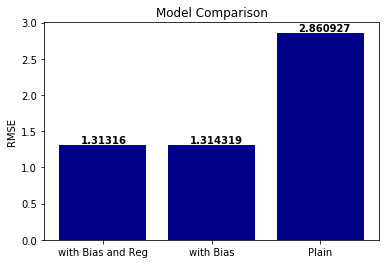

In [102]:
x = ['with Bias and Reg', 'with Bias', 'Plain']
y = [1.313160, 1.314319, 2.860927]

fig, ax = plt.subplots()
ind = np.arange(len(y))
width = 0.8
ax.bar(ind, y, width, color=['darkblue'])
ax.set_xticks(ind+width/500)
ax.set_xticklabels(x, minor=False)
ax.set_ylabel('RMSE')
ax.set_title('Model Comparison')
for i, v in enumerate(y):
    ax.text(i -0.2, v + 0.02, str(v), fontweight='bold')
plt.show()

## Best model train RMSE

### Best from Comparison

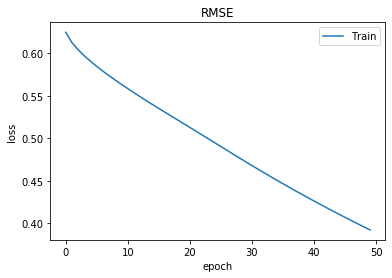

In [105]:
best = df_results_b.iloc[6]
model.plot_rmse(best['train_rmse'])

### Best of All Models

In [ ]:
best = df_results_all
model.plot_rmse(best['train_rmse'])

# Appendix

## Data Split (Pandas)

In [ ]:
# from scipy.linalg import sqrtm

# X_train, X_test = train_test_split(df, test_size=0.10, shuffle=True, random_state=1234)
# X_validation, X_test = train_test_split(X_test, test_size=0.50, shuffle=True, random_state=1234)

# def create_utility_matrix(data, formatizer = {'user':0, 'item': 1, 'value': 2}):
#     """
#         :param data:      Array-like, 2D, nx3
#         :param formatizer:pass the formatizer
#         :return:          utility matrix (n x m), n=users, m=items
#     """
        
#     itemField = formatizer['item']
#     userField = formatizer['user']
#     valueField = formatizer['value']
    
#     userList = data.iloc[:,userField].tolist()
#     itemList = data.iloc[:,itemField].tolist()
#     valueList = data.iloc[:,valueField].tolist()
    
#     users = list(set(data.iloc[:,userField]))
#     items = list(set(data.iloc[:,itemField]))
    
#     users_index = {users[i]: i for i in range(len(users))}
#     pd_dict = {item: [np.nan for i in range(len(users))] for item in items}
    
#     for i in range(0,len(data)):
#         item = itemList[i]
#         user = userList[i]
#         value = valueList[i]
        
#     pd_dict[item][users_index[user]] = value
#     X = pd.DataFrame(pd_dict)
#     X.index = users
        
#     itemcols = list(X.columns)
#     items_index = {itemcols[i]: i for i in range(len(itemcols))}
#     # users_index gives us a mapping of user_id to index of user
#     # items_index provides the same for items
#     return X, users_index, items_index

# X, users_index, items_index = create_utility_matrix(X_train)

hide_toggle()

## Create user item matrix

In [ ]:
# n_users = df.user.unique().shape[0]
# n_items = df.item.unique().shape[0]

# ratings_train = np.zeros((n_users, n_items))
# for row in X_train.itertuples():
#         ratings_train[row[5], row[4]] = row[3]

# pd.DataFrame(ratings_train).head()
# # sparse.csr_matrix((X_train['rating']),shape(n_users, n_items))
hide_toggle()

## Different SGD coding

In [ ]:
# user_item_combos = 0
# for epoch in range(n_epochs):
#     for u in range(ratings_train.shape[0]): #users
#         for i in range(ratings_train.shape[1]): #items
#             r_ui = ratings_train[u,i]
            
#             if  r_ui != 0:
#                 user_item_combos += 1
#                 error = r_ui - np.dot(p[u], q[i])
                
#                 p[u] += alpha *(error * q[i])
#                 q[i] += alpha * (error * p[u])
                
#                 total_error += np.square(error)
# #         print(total_error)
#     rmse = math.sqrt(total_error)
#     print('epoch: ', epoch)#, '  rmse: ', rmse)
#     print(user_item_combos, X_train['rating'].shape[0])
hide_toggle()

## With regularization

In [ ]:
# b_user[u] += alpha_b * (error - bu_reg * b_user[u])
# b_item[i] += alpha_b * (error - bi_reg * b_item[i])
            
# p[u] += alpha * (error * q[i] - pu_reg * p[u])
# q[i] += alpha * (error * p[u] - qi_reg * q[i])
hide_toggle()